In [1]:
!pip install --upgrade nx-cugraph-cu12 networkx rich httpx pandas numpy gensim tqdm nltk pyldavis ipykernel zstandard

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 856.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 49.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (

In [2]:
!export NETWORKX_AUTOMATIC_BACKENDS=cugraph

In [3]:
"""
This module contains utility functions for the project.
author: @lakshyaag
"""

import logging
import os

import httpx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
import nltk
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from rich import print

%load_ext rich
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

nltk.download("stopwords")
pd.set_option("display.max_columns", None)
pyLDAvis.enable_notebook()
tqdm.pandas()

os.makedirs("./data", exist_ok=True)
os.makedirs("./graphs", exist_ok=True)

dataloader_logger = logging.getLogger("DataLoader")

BASE_URL = "https://the-eye.eu/redarcs/files/"


def get_input_files(
    subreddit: str, type: str = "submissions", chunk_size: int = 10000
):
    """
    Fetches and downloads input files from the-eye.eu, subsequently returning the data as a pandas DataFrame.

    Parameters:
    - subreddit (str): The specific subreddit for which to download data.
    - type (str): The category of data to download, options include "submissions" or "comments".
    - chunk_size (int): The size of chunks for reading the data, enhancing performance for large files.

    Returns:
    - pd.DataFrame genrator: A generator object containing the data in chunks.
    """
    # Create data directory if it doesn't exist
    os.makedirs("./data", exist_ok=True)

    file_name = f"{subreddit}_{type}.zst"
    file_path = f"./data/{file_name}"
    json_read_params = {
        "compression": {
            "method": "zstd",
            "max_window_size": 2**31,
        },
        "lines": True,
    }

    if not os.path.exists(file_path):
        dataloader_logger.info(f"Downloading {type} for {subreddit}")
        url = BASE_URL + file_name
        with httpx.stream("GET", url) as r:
            r.raise_for_status()

            total_size_in_bytes = int(r.headers.get("content-length", 0))
            block_size = 1024  # 1 Kibibyte
            progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

            with open(file_path, "wb") as f:
                for data in r.iter_bytes(block_size):
                    progress_bar.update(len(data))
                    f.write(data)

            progress_bar.close()

            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                dataloader_logger.error("ERROR, something went wrong")

            dataloader_logger.info(f"Downloaded and saved {type} for {subreddit}")

    else:
        dataloader_logger.info(f"File {file_name} already exists")

    return pd.read_json(file_path, **json_read_params, chunksize=chunk_size)


def view_sample_graph(graph: nx.Graph, n: int = 50) -> nx.Graph:
    """
    Displays a sample graph with a specified number of nodes.

    Parameters:
    - graph (nx.Graph): The graph to sample from.
    - n (int): The number of nodes to sample.

    Returns:
    - nx.Graph: The sampled graph.
    """

    sample_nodes = np.random.choice(list(graph.nodes), n)
    sample_graph = graph.subgraph(sample_nodes)


    plt.figure(figsize=(20, 20))

    pos = nx.spring_layout(sample_graph)
    nx.draw(
        sample_graph,
        pos,
        with_labels=True,
        node_size=300,
        font_size=10,
    )
    plt.axis("off")
    plt.title(f"Sample Graph with {n} Nodes")
    plt.show()

    return sample_graph


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load data

In [4]:
SUBREDDIT_NAME = "google"

### Submissions

In [5]:
submission_columns_ = [
    "author",
    "created_utc",
    "domain",
    "id",
    "is_self",
    "num_comments",
    "score",
    "selftext",
    "subreddit",
    "subreddit_id",
    "subreddit_subscribers",
    "title",
    "url",
    "downs",
    "ups",
]

submissions = get_input_files(SUBREDDIT_NAME, type="submissions").read()[
    submission_columns_
]

submissions = submissions[~submissions["author"].isin(["[deleted]", "[removed]"])]

100%|██████████| 43.3M/43.3M [00:01<00:00, 29.4MiB/s]


### Comments

In [6]:
comments_columns_ = [
    "body",
    "name",
    "link_id",
    "parent_id",
    "downs",
    "subreddit",
    "score",
    "ups",
    "author",
    "created_utc",
    "permalink",
]


comments = get_input_files(SUBREDDIT_NAME, type="comments").read()[comments_columns_]

comments = comments[~comments["author"].isin(["[deleted]", "[removed]"])]
comments["submission_id"] = comments["link_id"].str.split("t3_").str[1]

100%|██████████| 70.5M/70.5M [00:01<00:00, 47.1MiB/s]


In [7]:
comments

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink,submission_id
0,Wow. The effect of cities on the terrain is ....,t1_c03449x,t3_67xq9,t3_67xq9,0.0,google,1,1.0,Prysorra,1202363492,NaN,67xq9
1,How so? Cities are normally built up on low ly...,t1_c0344hs,t3_67xq9,t1_c03449x,0.0,google,1,1.0,unripegreenbanana,1202365216,NaN,67xq9
2,The colors in the Atlanta area do not match to...,t1_c0344j4,t3_67xq9,t1_c0344hs,0.0,google,1,1.0,Prysorra,1202365452,NaN,67xq9
4,For more Google tricks check:\r\nhttp://www.ma...,t1_c0346ul,t3_67ytu,t3_67ytu,0.0,google,1,1.0,hoss-style,1202393345,NaN,67ytu
9,&gt;This way it could browse real businesses t...,t1_c03inif,t3_6d2c2,t3_6d2c2,0.0,google,1,1.0,shopcat,1206290555,NaN,6d2c2
...,...,...,...,...,...,...,...,...,...,...,...,...
740675,"I'm using an Android phone, and will install t...",t1_j2ft6ht,t3_zzce2i,t1_j2cppu5,NaN,google,1,NaN,SamuraiF0X,1672529193,/r/google/comments/zzce2i/premium_giveaway_for...,zzce2i
740676,I actually am seeking help. There was no good ...,t1_j2fty0r,t3_zzlqzb,t1_j2ccict,NaN,google,1,NaN,Technical_Bank1829,1672529537,/r/google/comments/zzlqzb/google_is_saying_unu...,zzlqzb
740677,Your talking about the company who ley there d...,t1_j2fu1zl,t3_zzt1fq,t1_j2fqp61,NaN,google,1,NaN,coolman9110996,1672529586,/r/google/comments/zzt1fq/never_knew_googlecom...,zzt1fq
740678,Lets see the actual certificate returned to th...,t1_j2fuuao,t3_zzt1fq,t3_zzt1fq,NaN,google,4,NaN,ghost-train,1672529939,/r/google/comments/zzt1fq/never_knew_googlecom...,zzt1fq


## Topic modeling

In [8]:
submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year

In [9]:
# Clean submission title
stop_words = stopwords.words("english")
stop_words.extend(["google"])

def clean_post_title(post):
    return " ".join(
        [
            word
            for word in simple_preprocess(post)
            if word not in stop_words and len(word) > 2
        ]
    )

In [10]:
sample = submissions["title"].sample(10, random_state=42).tolist()
print(sample)

sample_cleaned = [clean_post_title(post) for post in sample]
print(sample_cleaned)

[
    'Apply Now for Paid Google Summer Internship 2020 – Monthly Stipend $6000',
    'Prediksi Las Palmas vs Celta De Vigo 17 Oktober 2017',
    'Google Bulletin is the company’s first foray into crowdsourced, hyperlocal news',
    "What does the FCC's new ruling mean for Fiber?",
    'ConvertXtoDVD 4.1.7.343',
    'Facebook Messenger',
    "AJ wants to list Lenny's website on the first page in Google (x-post /r/itslenny)",
    'Yes, F security and privacy.',
    "'Google Now' even started notifying me of price changes of products I searched! Freaks me out",
    'Semantic Search Engine Omnity Claims That It Can Beat Google And Buy It.'
]

[
    'apply paid summer internship monthly stipend',
    'prediksi las palmas celta vigo oktober',
    'bulletin company first foray crowdsourced hyperlocal news',
    'fcc new ruling mean fiber',
    'convertxtodvd',
    'facebook messenger',
    'wants list lenny website first page post itslenny',
    'yes security privacy',
    'even started notifying price changes products searched freaks',
    'semantic search engine omnity claims beat buy'
]

In [11]:
submissions["clean_title"] = submissions["title"].progress_apply(clean_post_title)

100%|██████████| 190528/190528 [00:06<00:00, 28081.42it/s]


In [12]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title
0,mattevans,1201308801,informationweek.com,66nf3,False,0,6,,google,t5_2qh45,NaN,Google takes aim at domain tasting profiteers,http://www.informationweek.com/management/show...,NaN,NaN,2008,takes aim domain tasting profiteers
1,micahfk,1201803521,googlesearchsucks.com,67997,False,0,1,,google,t5_2qh45,NaN,Google Fails Citizenship Test,http://googlesearchsucks.com/google-fails-citi...,NaN,NaN,2008,fails citizenship test
2,mattevans,1201861278,news.com,67c2h,False,0,3,,google,t5_2qh45,NaN,"At Google, fewer 'Nooglers'",http://www.news.com/8301-10784_3-9862375-7.html,NaN,NaN,2008,fewer nooglers
3,mattevans,1202127332,theregister.co.uk,67le1,False,0,1,,google,t5_2qh45,NaN,Microhoo! marriage hits Google salaries hard,http://www.theregister.co.uk/2008/02/04/google...,NaN,NaN,2008,microhoo marriage hits salaries hard
4,Aaronontheweb,1202355557,techcrunch.com,67xf9,False,0,0,,google,t5_2qh45,NaN,Rumor: Is Google About to Buy Bebo For $1 Bill...,http://www.techcrunch.com/2008/02/06/rumor-is-...,NaN,NaN,2008,rumor buy bebo billion billion myspace
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227773,NikTebow,1672522034,self.google,10043xk,True,1,1,[removed],google,t5_2qh45,2069524.0,School google workspace account being deleted,https://www.reddit.com/r/google/comments/10043...,NaN,NaN,2022,school workspace account deleted
227775,Slow_Art3559,1672522621,mediafire.com,1004bc2,False,0,1,,google,t5_2qh45,2069524.0,Kenny Sletch_Labatsi áudio oficial unpload By ...,https://www.mediafire.com/file/lwbkwhuh4lqm94z...,NaN,NaN,2022,kenny sletch_labatsi áudio oficial unpload blo...
227777,SnarkyPuss,1672525925,self.google,1005f0p,True,2,0,Editing to clarify my post is about Google cal...,google,t5_2qh45,2069524.0,Holidays showing as events on personal calendar,https://www.reddit.com/r/google/comments/1005f...,NaN,NaN,2022,holidays showing events personal calendar
227778,TheGamingHusk,1672528032,self.google,100640t,True,0,1,[removed],google,t5_2qh45,2069524.0,Foreign Account,https://www.reddit.com/r/google/comments/10064...,NaN,NaN,2022,foreign account


In [13]:
titles = submissions['clean_title'].apply(str.split)
id2word = corpora.Dictionary(titles)

In [14]:
corpus = [id2word.doc2bow(title) for title in titles]

In [15]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=3,
    passes=5,
    iterations=200,
    random_state=42
)

In [16]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]


[
    (
        0,
        '0.025*"new" + 0.019*"chrome" + 0.015*"app" + 0.015*"com" + 0.014*"android" + 0.013*"apple" + 0.011*"store"
+ 0.010*"https" + 0.009*"play" + 0.008*"youtube"'
    ),
    (
        1,
        '0.037*"search" + 0.020*"drive" + 0.018*"شماره" + 0.017*"خاله" + 0.012*"photos" + 0.009*"results" + 
0.009*"home" + 0.007*"like" + 0.006*"music" + 0.006*"images"'
    ),
    (
        2,
        '0.024*"buy" + 0.019*"apple" + 0.016*"reviews" + 0.009*"news" + 0.008*"data" + 0.008*"photodollar" + 
0.008*"facebook" + 0.007*"amp" + 0.005*"star" + 0.005*"says"'
    ),
    (
        3,
        '0.026*"account" + 0.023*"help" + 0.015*"gmail" + 0.012*"phone" + 0.012*"get" + 0.011*"know" + 
0.011*"anyone" + 0.009*"need" + 0.008*"please" + 0.008*"email"'
    ),
    (
        4,
        '0.026*"pixel" + 0.025*"bitcoin" + 0.021*"apple" + 0.011*"watch" + 0.009*"best" + 0.009*"online" + 
0.009*"free" + 0.007*"iphone" + 0.007*"love" + 0.007*"pro"'
    )
]

In [17]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(
    topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.252000  0.042714       1        1  24.720922
0      0.006773 -0.123712       2        1  21.079483
1     -0.173270 -0.029955       3        1  19.218629
4      0.247073 -0.166672       4        1  17.579877
2      0.171425  0.277625       5        1  17.401089,
    topic_info=           Term         Freq        Total Category  logprob  loglift
34       search  7997.000000  7997.000000  Default  30.0000  30.0000
287     account  7130.000000  7130.000000  Default  29.0000  29.0000
13310     pixel  5178.000000  5178.000000  Default  28.0000  28.0000
650        help  6367.000000  6367.000000  Default  27.0000  27.0000
14124   bitcoin  4867.000000  4867.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
798     support   695.653070  2020.293907   Topic5  -5.6387   0.6825
266    business   665.262512  1935.022067   Topic5  -5.6834   0.6809
320        tech   665.195493  2211.235462   Topic5  -5.6835   0.5474
62         best   609.890848  3697.737518   Topic5  -5.7703  -0.0536
1077    content   573.354858  1091.523773   Topic5  -5.8320   1.1048

[307 rows x 6 columns],
    token_table=       Topic      Freq      Term
term                            
199        1  0.990021    access
199        5  0.009136    access
287        1  0.999788   account
287        5  0.000140   account
795        1  0.999441  accounts
...      ...       ...       ...
378        3  0.219598   youtube
378        5  0.002797   youtube
53885      3  0.997358     تهران
55678      3  0.999831      خاله
54152      3  0.999868     شماره

[527 rows x 3 columns],
    R=30,
    lambda_step=0.01,
    plot_opts={'xlab': 'PC1', 'ylab': 'PC2'},
    topic_order=[4, 1, 2, 5, 3]
)

In [18]:
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

print(topic_words)

[
    (
        0,
        [
            ('new', 0.024845043),
            ('chrome', 0.018830867),
            ('app', 0.0152125405),
            ('com', 0.01508773),
            ('android', 0.014358046),
            ('apple', 0.013014801),
            ('store', 0.011031829),
            ('https', 0.009631306),
            ('play', 0.008992825),
            ('youtube', 0.0075575043)
        ]
    ),
    (
        1,
        [
            ('search', 0.03691886),
            ('drive', 0.01956179),
            ('شماره', 0.0176076),
            ('خاله', 0.017432256),
            ('photos', 0.011953854),
            ('results', 0.008994537),
            ('home', 0.008667818),
            ('like', 0.0069064223),
            ('music', 0.005864904),
            ('images', 0.0056127133)
        ]
    ),
    (
        2,
        [
            ('buy', 0.02378967),
            ('apple', 0.018883409),
            ('reviews', 0.01610403),
            ('news', 0.009243743),
            ('data', 0.007956356),
            ('photodollar', 0.007691296),
            ('facebook', 0.007544111),
            ('amp', 0.007484879),
            ('star', 0.0047044023),
            ('says', 0.0045058816)
        ]
    ),
    (
        3,
        [
            ('account', 0.02566348),
            ('help', 0.022915317),
            ('gmail', 0.015120158),
            ('phone', 0.012370315),
            ('get', 0.011624042),
            ('know', 0.01105216),
            ('anyone', 0.010588523),
            ('need', 0.009346935),
            ('please', 0.0083315885),
            ('email', 0.007709482)
        ]
    ),
    (
        4,
        [
            ('pixel', 0.026206784),
            ('bitcoin', 0.024634445),
            ('apple', 0.021347435),
            ('watch', 0.01090917),
            ('best', 0.009341962),
            ('online', 0.009192785),
            ('free', 0.009067308),
            ('iphone', 0.0072291135),
            ('love', 0.006796352),
            ('pro', 0.0066099153)
        ]
    )
]

### Topic Summaries

#### Topic 0: Google products and services
  Keywords: "chrome", "android", "play", "youtube", "app"
  
  Summary: Focuses on Google's various products and services, highlighting mobile applications and platforms like Google Play Store.

#### Topic 1: Search and cloud storage
  Keywords: "search", "drive", "photos", "results", "files"
  
  Summary: Centers on Google's search capabilities and cloud storage solutions, specifically Google Drive and Google Photos.

#### Topic 2: Tech company news and reviews
  Keywords: "apple", "news", "facebook", "reviews", "data", "says"
  
  Summary: Captures discussions and news about major tech companies, comparing products and data practices among giants like Apple and Facebook.

#### Topic 3: Account support and troubleshooting
  Keywords: "account", "help", "gmail", "phone", "email", "need", "please"
  
  Summary: Relates to user support for Google accounts and services, with a strong emphasis on Gmail troubleshooting.

#### Topic 4: Hardware products
  Keywords: "pixel", "apple", "watch", "iphone", "pro"
  
  Summary: Discusses hardware products, comparing features, pricing, and reviews of items like Pixel phones, Apple Watch, and iPhones.

In [19]:
topic_names = {
    0: "Google products and services",
    1: "Search and cloud storage",
    2: "Tech company news and reviews",
    3: "Account support and troubleshooting",
    4: "Hardware products",
}

In [20]:
# Assign submission to topic
def assign_topic(lda_model, corpus, topic_interpretation):
    """
    Assigns a topic to each submission based on the topic with the highest probability

    :param lda_model: LDA model
    :param corpus: corpus
    :param topic_interpretation: dictionary with topic interpretation (e.g. {0: 'topic1', 1: 'topic2'})
    """
    doc_lda = lda_model[corpus]
    topics = [max(doc, key=lambda x: x[1])[0] for doc in doc_lda]
    return [topic_interpretation[topic] for topic in topics]


submissions["topic"] = assign_topic(lda_model, corpus, topic_names)

submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title,topic
0,mattevans,1201308801,informationweek.com,66nf3,False,0,6,,google,t5_2qh45,NaN,Google takes aim at domain tasting profiteers,http://www.informationweek.com/management/show...,NaN,NaN,2008,takes aim domain tasting profiteers,Hardware products
1,micahfk,1201803521,googlesearchsucks.com,67997,False,0,1,,google,t5_2qh45,NaN,Google Fails Citizenship Test,http://googlesearchsucks.com/google-fails-citi...,NaN,NaN,2008,fails citizenship test,Search and cloud storage
2,mattevans,1201861278,news.com,67c2h,False,0,3,,google,t5_2qh45,NaN,"At Google, fewer 'Nooglers'",http://www.news.com/8301-10784_3-9862375-7.html,NaN,NaN,2008,fewer nooglers,Search and cloud storage
3,mattevans,1202127332,theregister.co.uk,67le1,False,0,1,,google,t5_2qh45,NaN,Microhoo! marriage hits Google salaries hard,http://www.theregister.co.uk/2008/02/04/google...,NaN,NaN,2008,microhoo marriage hits salaries hard,Tech company news and reviews
4,Aaronontheweb,1202355557,techcrunch.com,67xf9,False,0,0,,google,t5_2qh45,NaN,Rumor: Is Google About to Buy Bebo For $1 Bill...,http://www.techcrunch.com/2008/02/06/rumor-is-...,NaN,NaN,2008,rumor buy bebo billion billion myspace,Tech company news and reviews
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227773,NikTebow,1672522034,self.google,10043xk,True,1,1,[removed],google,t5_2qh45,2069524.0,School google workspace account being deleted,https://www.reddit.com/r/google/comments/10043...,NaN,NaN,2022,school workspace account deleted,Account support and troubleshooting
227775,Slow_Art3559,1672522621,mediafire.com,1004bc2,False,0,1,,google,t5_2qh45,2069524.0,Kenny Sletch_Labatsi áudio oficial unpload By ...,https://www.mediafire.com/file/lwbkwhuh4lqm94z...,NaN,NaN,2022,kenny sletch_labatsi áudio oficial unpload blo...,Account support and troubleshooting
227777,SnarkyPuss,1672525925,self.google,1005f0p,True,2,0,Editing to clarify my post is about Google cal...,google,t5_2qh45,2069524.0,Holidays showing as events on personal calendar,https://www.reddit.com/r/google/comments/1005f...,NaN,NaN,2022,holidays showing events personal calendar,Account support and troubleshooting
227778,TheGamingHusk,1672528032,self.google,100640t,True,0,1,[removed],google,t5_2qh45,2069524.0,Foreign Account,https://www.reddit.com/r/google/comments/10064...,NaN,NaN,2022,foreign account,Account support and troubleshooting


In [21]:
def get_topic_submissions(topic_id):
    submission_t = submissions[submissions["topic"] == SELECTED_TOPIC]
    comments_t = comments[comments["submission_id"].isin(submission_t["id"])]

    return submission_t, comments_t

## Network analysis

### Create bipartite graph

In [22]:
def create_bipartite_graph(df: pd.DataFrame):
    B = nx.Graph()

    users = df["author"].unique()
    posts = df["link_id"].unique()

    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(posts, bipartite=1)

    edges = [
        (row["author"], row["link_id"], row["score"]) for index, row in df.iterrows()
    ]

    B.add_weighted_edges_from(edges)

    if nx.is_bipartite(B):
        user_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
        post_nodes = set(B) - user_nodes

    return user_nodes, post_nodes, B


def project_bipartite_graph(B, nodes):
    return nx.bipartite.weighted_projected_graph(B, nodes)


In [23]:
def create_topic_network(topic_id):
    submission_t, comments_t = get_topic_submissions(topic_id)

    user_weights = (
        comments_t.groupby("author")
        .agg({"score": "mean", "body": "count"})
        .rename(columns={"score": "average_score", "body": "num_comments"})
        .sort_values(by=["num_comments", "average_score"], ascending=False)
    )

    user_weights

    user_nodes_t, post_nodes_t, B_t = create_bipartite_graph(comments_t)

    G_user_t = project_bipartite_graph(B_t, user_nodes_t)

    # G_post_t = project_bipartite_graph(B_t, post_nodes_t)

    for attribute in user_weights.columns:
        nx.set_node_attributes(
            G_user_t,
            pd.Series(user_weights[attribute], index=user_weights.index).to_dict(),
            attribute,
        )

    return G_user_t, user_weights


In [24]:
def get_largest_component(G):
    largest_cc_t = max(nx.connected_components(G), key=len)
    G_largest_cc_t = G.subgraph(largest_cc_t)

    print(
        f"Largest component has {len(G_largest_cc_t.nodes)} nodes and {len(G_largest_cc_t.edges)} edges."
    )

    return G_largest_cc_t


In [25]:
def calculate_centralities(G):
    degree_centrality = pd.DataFrame(
        nx.degree_centrality(G, backend='cugraph').items(),
        columns=["author", "degree_centrality"],
    ).sort_values(by="degree_centrality", ascending=False)

    betweenness_centrality = pd.DataFrame(
        nx.betweenness_centrality(G, k=100, backend='cugraph').items(),
        columns=["author", "betweenness_centrality"],
    ).sort_values(by="betweenness_centrality", ascending=False)
    eigenvector_centrality = pd.DataFrame(
        nx.eigenvector_centrality(G, backend='cugraph').items(),
        columns=["author", "eigenvector_centrality"],
    ).sort_values(by="eigenvector_centrality", ascending=False)

    centrality_scores = pd.concat(
        [
            degree_centrality.set_index("author"),
            betweenness_centrality.set_index("author"),
            eigenvector_centrality.set_index("author"),
        ],
        axis=1,
    )

    return centrality_scores


In [26]:
def build_node_data(G):
    centrality_scores = calculate_centralities(G)

    filtered_node_data = pd.DataFrame(G.nodes(data=True), columns=["author", "attrs"])

    filtered_node_data = (
        pd.concat(
            [
                filtered_node_data["author"],
                pd.json_normalize(filtered_node_data["attrs"]),
            ],
            axis=1,
        )
        .set_index("author")
        .merge(centrality_scores, left_index=True, right_index=True)
    )

    filtered_node_data["influencer_score"] = (
        filtered_node_data["degree_centrality"]
        + filtered_node_data["betweenness_centrality"]
        + filtered_node_data["eigenvector_centrality"]
    ) * filtered_node_data["num_comments"]

    filtered_node_data = filtered_node_data.sort_values(
        by="influencer_score", ascending=False
    )

    return filtered_node_data


In [27]:
def get_communities(G):
    communities = nx.community.louvain_communities(
        G, weight="weight", seed=42, backend="cugraph"
    )
    # Add community as node attribute to the graph
    for community_idx, community in enumerate(communities):
        for node in community:
            G.nodes[node]["community"] = community_idx

    community_lens = {i: len(x) for i, x in enumerate(communities)}

    return communities, community_lens

In [64]:
def plot_community_graph(G, communities, community_lens, community_idx, SELECTED_TOPIC):
    G_filtered_community = G.subgraph(communities[community_idx])

    # Calculate node sizes based on influencer scores
    influencer_scores = [d.get("influencer_score", 0) for n, d in G_filtered_community.nodes(data=True)]
    max_score = max(influencer_scores)
    node_size = [(score / max_score) * 1000 for score in influencer_scores]

    top_degree_nodes = sorted(
        G_filtered_community.nodes(data=True), key=lambda x: x[1]["degree_centrality"]
    )[-10:]

    top_betweenness_nodes = sorted(
        G_filtered_community.nodes(data=True),
        key=lambda x: x[1]["betweenness_centrality"],
    )[-10:]

    nodes_label = top_degree_nodes + top_betweenness_nodes

    labels = {node[0]: node[0] for node in nodes_label}

    plt.figure(figsize=(20, 20))

    fig, ax = plt.subplots(figsize=(20, 15))

    pos = nx.kamada_kawai_layout(G_filtered_community, weight="weight")

    ax.set_axis_off()
    nx.draw_networkx_nodes(
        G_filtered_community,
        pos,
        node_size=node_size,
        node_color="red",
        ax=ax,
    )

    nx.draw_networkx_edges(
        G_filtered_community,
        pos,
        alpha=0.2,
        width=0.8,
        edge_color="grey",
        ax=ax,
    )
    nx.draw_networkx_labels(G_filtered_community, pos, labels, font_size=12)

    plt.title(
        f"Network plot for Community {community_idx} with {community_lens[community_idx]} nodes\nTopic: {SELECTED_TOPIC}\nNode size based on influencer score"
    )
    plt.savefig(f"./graphs/{SELECTED_TOPIC}_community_{community_idx}.png", dpi=300)

    plt.show()

    avg_clustering_coeff = nx.average_clustering(
        G_filtered_community, weight="weight", count_zeros=False
    )

    print(f"Average clustering coefficient: {avg_clustering_coeff}")

    return G_filtered_community


In [29]:
def get_top_users(G, n=10):
    top_users = sorted(
        G.nodes(data=True), key=lambda x: x[1]["influencer_score"], reverse=True
    )[:n]

    return top_users


In [41]:
def get_filtered_topic_graph(SELECTED_TOPIC):
    G_user_t, user_weights = create_topic_network(SELECTED_TOPIC)

    print(f"Selected topic: {SELECTED_TOPIC}")

    print(f"The graph has {len(G_user_t.nodes)} nodes and {len(G_user_t.edges)} edges.")

    G_largest_cc_t = get_largest_component(G_user_t)

    # view_sample_graph(G_largest_cc_t, 100)

    # Filter nodes based on the number of comments
    nodes_with_more_than_one_comment = [
        node
        for node, attr in G_largest_cc_t.nodes(data=True)
        if attr.get("num_comments", 0) > 1
    ]

    G_filtered = G_largest_cc_t.subgraph(nodes_with_more_than_one_comment)

    print(
        f"After filtering for nodes with more than one comment, the graph has {len(G_filtered.nodes)} nodes and {len(G_filtered.edges)} edges."
    )

    filtered_node_data = build_node_data(G_filtered)

    # Add centrality scores and influencer score as node attributes
    attributes = filtered_node_data[
        [
            "degree_centrality",
            "betweenness_centrality",
            "eigenvector_centrality",
            "influencer_score",
        ]
    ].to_dict("index")
    nx.set_node_attributes(G_filtered, attributes)

    return G_filtered, filtered_node_data

In [67]:
def get_community_dataframe(G):
  community_nodes_df = pd.DataFrame(G.nodes(data=True), columns=['author', 'attrs'])
  community_nodes_df = (
          pd.concat(
              [
                  community_nodes_df["author"],
                  pd.json_normalize(community_nodes_df["attrs"]),
              ],
              axis=1,
          )
      ).sort_values(by='degree_centrality', ascending=False)

  return community_nodes_df


In [39]:
SELECTED_TOPIC = topic_names[2]
print(f'Selected topic: {SELECTED_TOPIC}')

Selected topic: Tech company news and reviews

In [42]:
G_filtered, filtered_node_data = get_filtered_topic_graph(SELECTED_TOPIC)

communities, community_lens = get_communities(G_filtered)

print(f"Number of communities: {len(communities)}")
print(f"Community lengths: {community_lens}")

Selected topic: Tech company news and reviews

The graph has 31553 nodes and 2317315 edges.

Largest component has 29501 nodes and 2315302 edges.

After filtering for nodes with more than one comment, the graph has 11209 nodes and 456037 edges.

Number of communities: 28

Community lengths: {0: 3633, 1: 3342, 2: 284, 3: 582, 4: 263, 5: 245, 6: 267, 7: 809, 8: 515, 9: 607, 10: 210, 11: 
35, 12: 79, 13: 51, 14: 104, 15: 58, 16: 27, 17: 5, 18: 3, 19: 6, 20: 28, 21: 9, 22: 13, 23: 8, 24: 10, 25: 10, 26:
3, 27: 3}

<Figure size 2000x2000 with 0 Axes>

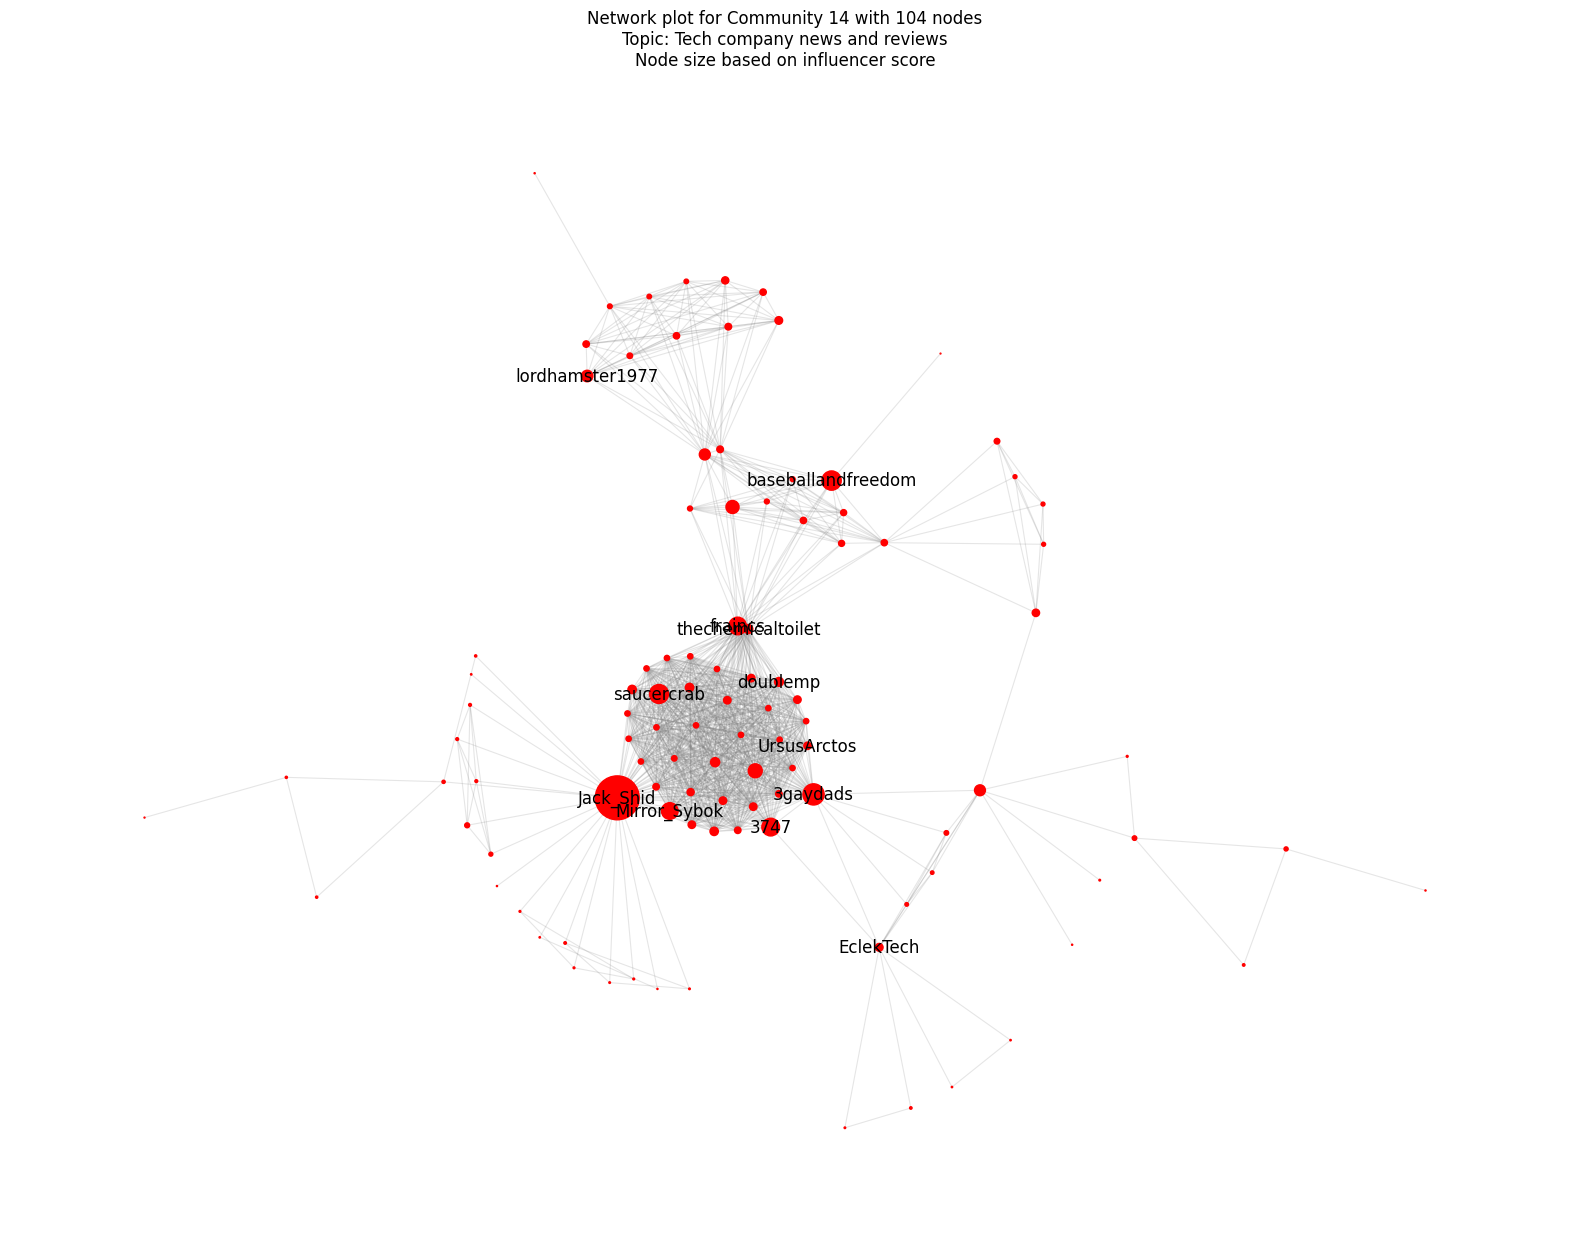

Average clustering coefficient: 0.4612119376244365

In [68]:
SELECTED_COMMUNITY_IDX = 14
G_community = plot_community_graph(G_filtered, communities, community_lens, SELECTED_COMMUNITY_IDX, SELECTED_TOPIC)

In [69]:
get_community_dataframe(G_community)

,author,bipartite,average_score,num_comments,degree_centrality,betweenness_centrality,eigenvector_centrality,influencer_score,community
66,Mirror_Sybok,0,1.600000,5,0.012045,0.002202,1.078662e-03,0.076629,14
77,3gaydads,0,2.222222,9,0.010617,0.001772,1.381740e-03,0.123944,14
46,fraincs,0,17.166667,6,0.010439,0.001947,1.904350e-03,0.085744,14
51,Jack_Shid,0,2.275862,29,0.009904,0.007520,9.452051e-04,0.532690,14
82,3747,0,7.857143,7,0.008476,0.002540,1.340083e-03,0.086492,14
...,...,...,...,...,...,...,...,...,...
4,AmuletIndustries,0,1.000000,3,0.000178,0.000000,8.185300e-05,0.000781,14
34,JacketJam,0,2.000000,2,0.000178,0.000000,3.906164e-06,0.000365,14
20,GTfour80,0,1.000000,3,0.000089,0.000000,2.338708e-09,0.000268,14
99,jctusa7,0,1.500000,2,0.000089,0.000000,8.313126e-06,0.000195,14
